In [1]:
import pandas as pd 
import numpy as np
import keras
from keras.layers import*
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
import re
from keras.models import *
from sklearn.utils import shuffle

In [4]:
### hyperparameters
EPOCHS=100
BATCH_SIZE=32
MAX_SENTENCE_COUNT=1
MAX_SENTENCE_LENGTH=40
VOCAB_SIZE=15000
EMBED_DIM=300
PATIENCE=3

In [11]:
df = pd.read_csv('sentiment140.csv',encoding='latin-1')
df = df[['label','tweet']]
df["label"].replace({4 : 1}, inplace=True)
df = shuffle(df)

In [12]:
df

,label,tweet
1307112,1,good morning Morning Wolf. http://tinyurl.com...
957257,1,@ptvjaime Happy Birthday Hi-Me
1562894,1,yeeaahhh. UP and Kabuki tomorrow with Maddie! ...
1574197,1,@torretwit lol i have never done a pub quiz bu...
1337639,1,"Band myspace is looking goooood, having a doob..."
...,...,...
194215,0,half-term is nearly over
26668,0,@TerenceSmelser Congrats! Does this mean you ...
1375953,1,hello for a little bit twitterbugs! miss you all
1151550,1,Twittering from my new iPhone


In [13]:
def processed_data(data):
    data['tweet'] = data['tweet'].apply(lambda x: x.lower())
    data['tweet'] = data['tweet'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

    return data

def x_value(data):
    tokenizer = Tokenizer(num_words = VOCAB_SIZE, split=" ")
    tokenizer.fit_on_texts(data['tweet'].values)
    x = tokenizer.texts_to_sequences(data['tweet'].values)
    x = pad_sequences(x, padding='post', maxlen=MAX_SENTENCE_LENGTH)
    
    return x

y = pd.get_dummies(df['label'])
y = y.to_numpy()
x = processed_data(df)
x = x_value(df)

In [14]:
### Attention
import keras.backend as K

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [15]:
inputs = Input(shape=(MAX_SENTENCE_LENGTH,))
embed = Embedding(input_dim=VOCAB_SIZE,
                  output_dim=EMBED_DIM,
                  input_length=MAX_SENTENCE_LENGTH)(inputs)

word_encoder = Bidirectional(CuDNNLSTM(units=64,return_sequences=True,name='bilstm'))(embed)

dense_transform_w = Dense(100,activation='relu',name='dense_transform_w')(word_encoder)

att = attention(name='word_attention')(dense_transform_w)

output = Dense(2,activation='softmax')(att)

model = keras.Model(inputs, output)
word_attention_model = model
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 40, 300)           4500000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 40, 128)          187392    
 nal)                                                            
                                                                 
 dense_transform_w (Dense)   (None, 40, 100)           12900     
                                                                 
 word_attention (attention)  (None, 100)               140       
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                           

In [16]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(monitor='accuracy', 
                                               mode='auto', 
                                               patience=PATIENCE, 
                                               verbose=1)

In [17]:
hist = model.fit(x, y, 
          epochs=5, 
          batch_size=BATCH_SIZE, 
          verbose=1,
          callbacks=[early_stopping])

50000/50000 [==============================] - 515s 10ms/step - loss: 0.3411 - accuracy: 0.8502
Epoch 5/5
50000/50000 [==============================] - 512s 10ms/step - loss: 0.3320 - accuracy: 0.8551


In [21]:
tokenizer = Tokenizer(num_words = VOCAB_SIZE, split=" ")
tokenizer.fit_on_texts(df['tweet'].values)

In [31]:
a = ["I am happy"]
text = a
a = tokenizer.texts_to_sequences(a)
a = np.array(a)
a = pad_sequences(a, padding='post', maxlen=MAX_SENTENCE_LENGTH)
prediction = model.predict(np.array(a))
print(np.argmax(prediction))

1


In [32]:
import string
from spacy.lang.en import English
from spacy.tokenizer import Tokenizer

STOP_WORDS = ['the', 'a', 'an']
nlp = English()
nlp.add_pipe(nlp.create_pipe('sentencizer'))

def normalize(text):
    text = text.lower().strip()
    doc = nlp(text)
    filtered_sentences = []
    for sentence in doc.sents:
        filtered_tokens = list()
        for i, w in enumerate(sentence):
            s = w.string.strip()
            if len(s) == 0 or s in string.punctuation and i < len(doc) - 1:
                continue
            if s not in STOP_WORDS:
                s = s.replace(',', '.')
                filtered_tokens.append(s)
        filtered_sentences.append(' '.join(filtered_tokens))
    return filtered_sentences

In [33]:
def _encode_texts(texts):
		encoded_texts = np.zeros((len(texts), MAX_SENTENCE_COUNT, MAX_SENTENCE_LENGTH))
		for i, text in enumerate(texts):
			encoded_text = np.array(pad_sequences(
				tokenizer.texts_to_sequences(text), 
				maxlen=MAX_SENTENCE_LENGTH))[:MAX_SENTENCE_COUNT]
			encoded_texts[i][-len(encoded_text):] = encoded_text
		return encoded_texts

In [34]:
reverse_word_index = {value:key for key,value in tokenizer.word_index.items()}
def _encode_input(x, log=False):
        x = np.array(x)
        if not x.shape:
            x = np.expand_dims(x, 0)
        texts = np.array([normalize(text) for text in x])
        return _encode_texts(texts)

In [35]:
def req(text):
    normalized_text = text
    encoded_text = _encode_input(text)[0]
    hidden_word_encoding_out = Model(inputs=word_attention_model.input,
                                    outputs=word_attention_model.get_layer('dense_transform_w').output)
    hidden_word_encodings = hidden_word_encoding_out.predict(encoded_text)
    word_context = word_attention_model.get_layer('word_attention').get_weights()[0]
    u_wattention = encoded_text*np.exp(np.squeeze(np.dot(hidden_word_encodings, word_context)))
  # generate word, activation pairs
    nopad_encoded_text = encoded_text[-len(normalized_text):]
    nopad_encoded_text = [list(filter(lambda x: x > 0, sentence)) for sentence in nopad_encoded_text]
    reconstructed_texts = [[reverse_word_index[int(i)] 
                  for i in sentence] for sentence in nopad_encoded_text]
    nopad_wattention = u_wattention[-len(normalized_text):]
    nopad_wattention = nopad_wattention/np.expand_dims(np.sum(nopad_wattention, -1), -1)
    nopad_wattention = np.array([attention_seq[-len(sentence):] 
                for attention_seq, sentence in zip(nopad_wattention, nopad_encoded_text)])
    word_activation_maps = []
    for i, text in enumerate(reconstructed_texts):
        word_activation_maps.append(list(zip(text, nopad_wattention[i])))

    return word_activation_maps

In [187]:
def heatmap(text):
  import matplotlib.pyplot as plt
  import seaborn as sns
  import pandas as pd

  req_list=req(text)
  arr = np.array(req_list)
  shape = arr.shape
  new_arr=np.reshape(arr, (shape[1],shape[2]), order = 'C')
  data_word=(new_arr.T[0]).tolist()
  data_att=(new_arr.T[1]).tolist()
  data_att=list(np.float_(data_att))
  sns.set()
  data_att = [data_att]
              
  d = pd.DataFrame(data = data_att, columns=data_word)
  f, ax = plt.subplots(figsize=(10,0.5))
  sns.heatmap(d, vmin=0, vmax=1.0, ax=ax, cmap="seismic")
  label_x = ax.get_xticklabels()
  plt.setp(label_x, rotation=90, horizontalalignment='right')
  plt.show()

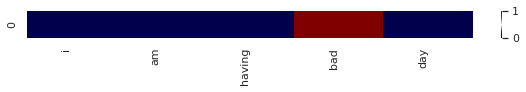

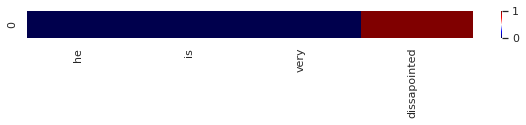

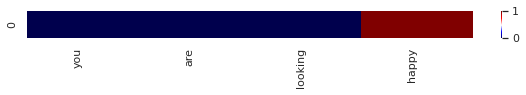

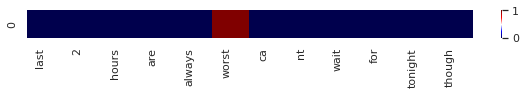

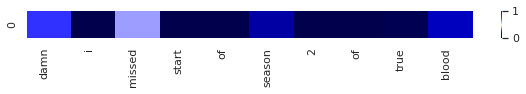

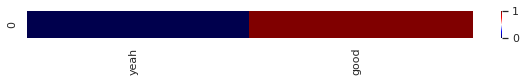

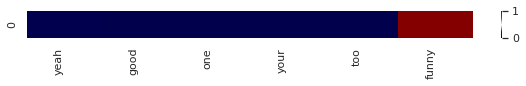

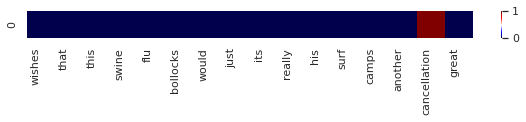

In [188]:
heatmap('I am having a bad day')
heatmap('He is very dissapointed')
heatmap('You are looking happy')
heatmap('the last 2 hours are always the worst cant wait for tonight though')
heatmap('damn i missed the start of season 2 of true blood')
heatmap('yeah good')
heatmap('mandsywoo yeah good one your too funny')
heatmap('wishes that this swine flu bollocks would just cease its really effecting his surf camps another cancellation great')